# Charged CompSpec Network

## Intro

* **Date**: 11/26/2020
* **What**: This is a [mini-batched CompSpec network](../11_26_2020_experiment_comp_spec_mini_batch) with local repulsion (charge).  So in addition to its specializing, fast learning properties, this network will also have local repulsion to make the neurons even more specialized.  
* **Why**: According to [Dima and John](https://www.pnas.org/content/116/16/7723), having local repulsion helps the network better differentiate between inputs.  That certainly makes sense.  Also, there isn't any notion of negative input synapses in Diehl's network, so this may be the step that allows me to thoroughly trounce [Diehl's SNN](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full) network into the ground.  I should also mention that apparently with biological neurons, synapses (and actually entire neurons) are either excitatory or inhibitory, so what I'm implementing here doesn't actually have a direct analog in biological systems. Well actually that's not true.  I guess you could have an excitatory neuron wired directly to an inhibitory neuron...it doesn't matter.  Let's just see if this thing works.
* **Hopes**: My humble desire is to absolutely obliterate Diehl's SNN.  But for real, I want this network to level up, even from where it was in the past experiment, so we actually reach god-tier.  I also hope it actually converges.  I guess there's a possibility that it would do that, given inhibition and everything.  Basically I want it to be even better than my already disgustingly good algorithm.
* **Limitations**: As I just mentioned, I suppose it's possible that this network wouldn't converge.  I really have no idea if that will be the case, but I suppose we'll see soon enough.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [2]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()  

In [3]:
def wta_classification(w, T_s, verbose):    
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w @ (flat_x[:T_s, :]).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    
    if verbose:
        print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    if verbose: print("Misclassifieds: ", incorrect)

In [4]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
k: Rank of the repelled neuron
delta: local repulsion constant (should be less than 1)
B: Batch size

Returns: (synapse_weights, neuron specialization values)
"""
def run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, delta, k, B):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S), :]

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B, :]

            w_mul_v = w @ v.T 
            o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

            c = ((1 - s) ** 2) / (1 - o)
            
            c_sort = np.argsort(c, axis=0)

            wins = c_sort[N - 1]

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            del_syn = (v_update - (win_avg * w)) * (((1 - s) ** 2) + 0.1) * xi
            
            repelled = c_sort[N - 1 - k]
            
            repel_mask = np.zeros((N, B))
            repel_mask[repelled, np.arange(B)] = 1
            repel_mask = (repel_mask / np.maximum(np.sum(repel_mask, axis=1), 1).reshape(-1, 1))
            repel_mask *= -1 * delta
            
            repel_avg = (np.sum(w_mul_v * repel_mask, axis=1)).reshape(-1, 1)
            
            v_repel_update = repel_mask @ v
            
            del_repel_syn = (v_repel_update - (repel_avg * w)) * ((s ** 2)) * xi
            
            w += del_syn + del_repel_syn
            
            if np.amax(np.abs(w)) > 10:
                w /= np.array([np.linalg.norm(w, axis=1)]).T
            
            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)
            
    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s)

## Analysis Dialogue

Well...I don't really know what to think.  I'll just show you a couple runs, and then I'll say more.  Oh, I should probably mention that it work.  That's a win, I suppose.  

100%|██████████| 300/300 [00:01<00:00, 250.80it/s]


Max val:  0.9314722515145933 Min value:  0.6323442088119072 Mean val:  0.8544383344042504 Std:  0.040963191780470226
Elapsed time:  1.3953561782836914  seconds


Neuron classes: [4 9 4 1 3 0 6 1 0 6 5 2 7 0 9 1 7 5 7 3 6 8 5 6 3 3 5 1 3 0 5 0 9 7 7 6 1
 6 2 1 8 0 7 6 6 7 6 0 2 0 2 6 8 3 1 7 5 9 6 7 1 2 1 3 0 4 9 5 7 7 3 0 0 2
 7 7 4 3 6 8 8 4 3 3 2 1 1 8 2 9 3 6 0 8 9 2 9 8 2 9]
Accuracy: 75.73%
Misclassifieds:  [ 35.  49. 538. 242. 543. 372. 131. 127. 142. 248.]


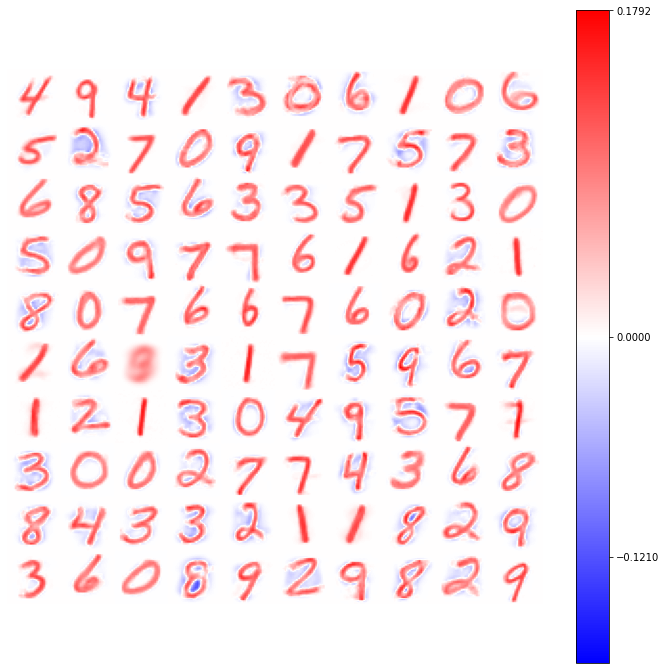

In [60]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11
delta = 0.01
B = 200 #Batch size

k = 4

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, delta, k, B)
print("\n")
wta_classification(w, T_s, True)
draw_weights(w, Kx, Ky)

100%|██████████| 300/300 [00:07<00:00, 39.69it/s]


Max val:  0.9435606337205598 Min value:  0.6312841306609424 Mean val:  0.8354055914903552 Std:  0.04110547783617716
Elapsed time:  7.758635759353638  seconds


Neuron classes: [4 0 2 4 3 2 0 7 7 0 1 2 7 7 3 6 5 3 6 8 2 5 4 0 2 0 9 1 9 2 1 6 0 6 4 3 8
 6 5 9 6 3 0 0 2 6 4 0 6 6 7 7 1 7 2 0 7 0 3 6 1 4 3 6 4 9 2 0 1 9 2 8 0 7
 8 3 7 5 0 7 6 9 9 0 5 6 5 4 0 3 0 9 0 7 0 6 9 0 9 5 2 7 5 0 0 8 0 7 0 1 9
 1 5 0 0 6 0 9 4 4 0 6 0 5 7 6 6 0 1 1 0 0 9 7 6 0 2 0 6 0 4 2 5 0 0 0 7 4
 6 3 9 2 6 0 6 5 0 7 3 2 4 0 9 4 0 2 4 5 6 2 4 2 1 7 4 0 1 6 0 0 9 0 3 5 6
 6 9 4 3 0 9 7 4 9 9 1 8 9 3 0 1 6 6 8 3 7 0 2 0 3 8 3 2 0 0 0 2 2 3 0 0 3
 0 0 0 1 3 6 0 5 3 5 1 1 6 3 0 0 0 3 9 1 3 5 7 1 0 8 0 2 7 8 9 9 0 1 2 0 4
 9 1 2 7 2 4 0 3 6 0 6 9 0 1 6 3 0 0 8 7 4 8 6 9 2 1 4 6 7 0 9 0 1 0 9 0 2
 0 3 3 7 7 6 4 0 7 1 3 9 0 7 1 6 2 9 1 3 4 3 0 3 0 2 4 0 0 8 4 6 7 6 0 0 6
 4 0 0 9 6 9 1 8 0 0 9 1 0 7 0 2 0 2 2 0 3 0 4 6 0 0 8 9 1 4 4 6 0 0 6 5 3
 3 6 1 0 2 0 6 2 3 5 0 9 0 6 2 4 6 0 9 2 1 3 0 7 2 0 0 1 4 7]
Accuracy: 66

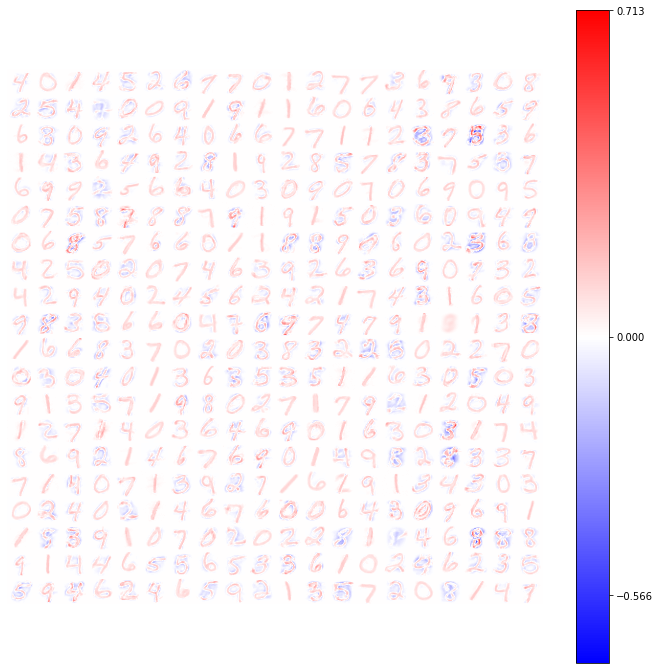

In [61]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11
delta = 0.05
B = 200 #Batch size

k = 4

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, delta, k, B)
print("\n")
wta_classification(w, T_s, True)
draw_weights(w, Kx, Ky)

100%|██████████| 300/300 [00:33<00:00,  8.95it/s]


Max val:  0.8811157975547703 Min value:  0.21515440061217495 Mean val:  0.6044057482462876 Std:  0.09162623289669278
Elapsed time:  33.72979283332825  seconds


Neuron classes: [0 5 0 ... 2 5 0]
Accuracy: 87.34%
Misclassifieds:  [ 14.  15.  93. 211. 245. 157.  60. 114. 216. 141.]


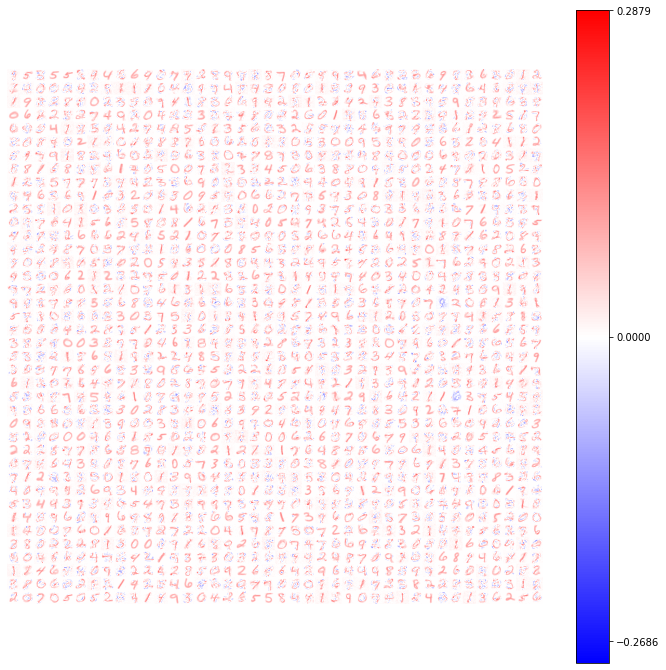

In [5]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 40
Ky = 40
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11
delta = 2
B = 200 #Batch size

k = 4

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, delta, k, B)
print("\n")
w /= np.array([np.linalg.norm(w, axis=1)]).T
wta_classification(w, T_s, True)

draw_weights(w, Kx, Ky)

While I was running this, I realized I should also talk about how I got this to work.  Initially, I just implemented repulsion using when exact same method as before.  However, that didn't work out because unspecialized neurons were getting blasted in the opposite direction initially.  Then I had a brainwave: repulsion only happens "locally" so it should only really affect specialized neurons.  So anyway, I flipped around the quadratic, and now more repulsion occurs for more specialized neurons.  I'm not entirely sure why this is the case, but I also found that I need to increase $\Delta$ as I increase the network size for it to have the same effect.  

As you can tell, the wta classifier doesn't do as well for this, but that kinda makes sense.  I don't really have a good way to put it into words, but I just feel like this sort of training would get a higher classification if it were incorporated into a neural network.  There's maybe just more differentiation, I guess?

Anyway, I guess that's all I have to say about this experiment.  I guess I'll bop on over to the conclusion section.

## Conclusions

It works.  Cool.  I like large numbers that make me feel good about myself, so this isn't as exciting as the mini-batch experiment.  That being said, it's cool that it works, and that network specialization gives me a better way to implement repulsion.  I think I may need to figure out a way to keep the repulsion stable.  Well, first I need to see if it even matters.  Anyway it works.

## Next Steps

I'm needed for thanksgiving.  Stick this into TensorFlow and watch it go.  The end.